In [9]:
# Environment & PPO Training Notebook

import gymnasium as gym
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from gymnasium.wrappers import FlattenObservation
import pandas as pd
import csv
import os

# Import project modules
from system_configuration import Config
from environment import SecCom_Env
from model.ppo import Agent, PPOConfig

# --- Configuration ---
# Load configuration from system_configuration.py
config = Config()
# IMPORTANT: Initialize dynamic values
config.init_unstatic_value()

# Load PPO hyperparameters from model/ppo.py (which defaults to main.py's settings)
ppo_args = PPOConfig()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Environment Setup ---
# Create the environment matching main.py
env = SecCom_Env(config)

# Wrap environment to flatten the Dict observation space into a Box
# maximizing compatibility with the MLP Agent
env = FlattenObservation(env)

# Verify observation space
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

# --- Agent Setup ---
# Initialize Agent with flattened observation space and action space
agent = Agent(env.observation_space.shape, env.action_space.shape).to(device)
optimizer = optim.Adam(agent.parameters(), lr=ppo_args.learning_rate, eps=1e-5)

# --- Storage Setup ---
# Buffers for PPO update
# Note: num_envs = 1 for this setup as per user request ("1 environment initialization")
num_envs = 1
num_steps = ppo_args.num_steps

obs = torch.zeros((num_steps, num_envs) + env.observation_space.shape).to(device)
actions = torch.zeros((num_steps, num_envs) + env.action_space.shape).to(device)
logprobs = torch.zeros((num_steps, num_envs)).to(device)
rewards = torch.zeros((num_steps, num_envs)).to(device)
dones = torch.zeros((num_steps, num_envs)).to(device)
values = torch.zeros((num_steps, num_envs)).to(device)

# --- Metrics Storage ---
global_step = 0
total_timesteps = config.max_steps # 300,000 based on user request/config
num_updates = total_timesteps // num_steps

# CSV Setup
csv_dir = "train_csv_2"
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir, exist_ok=True)

secrecy_file = os.path.join(csv_dir, "secrecy_rate.csv")
user_secrecy_file = os.path.join(csv_dir, "user_secrecy_rates.csv")

# Initialize CSVs
with open(secrecy_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["step", "secrecy_rate"])
    
# User header will be written on first step
with open(user_secrecy_file, 'w', newline='') as f:
    pass

user_header_written = False

# --- Training Loop ---
print(f"Starting training for {total_timesteps} steps...")

# Initialize environment once
next_obs, _ = env.reset(seed=42)
next_obs = torch.Tensor(next_obs).to(device)
next_done = torch.zeros(num_envs).to(device)

for update in range(1, num_updates + 1):
    # Annealing the rate if instructed to do so.
    frac = 1.0 - (update - 1.0) / num_updates
    lrnow = frac * ppo_args.learning_rate
    optimizer.param_groups[0]["lr"] = lrnow

    # Collect data for num_steps
    for step in range(0, num_steps):
        global_step += 1
        obs[step] = next_obs
        dones[step] = next_done

        # Get action
        with torch.no_grad():
            if len(next_obs.shape) == 1:
                input_obs = next_obs.unsqueeze(0)
            else:
                input_obs = next_obs
                
            action, logprob, _, value = agent.get_action_and_value(input_obs)
            values[step] = value.flatten()
            
        actions[step] = action
        logprobs[step] = logprob

        # Execute action
        real_action = action.cpu().numpy()[0] # Shape (action_dim,)
        next_obs_np, reward, terminated, truncated, info = env.step(real_action)
        
        # Track metrics
        secrecy_rate = env.unwrapped.basestation.get_secretary_rate().sum()
        user_rates = env.unwrapped.basestation.get_secretary_rate()
        
        # Write to CSV
        with open(secrecy_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([global_step, secrecy_rate])
            
        with open(user_secrecy_file, 'a', newline='') as f:
            writer = csv.writer(f)
            if not user_header_written:
                header = ["step"] + [f"User {i+1}" for i in range(len(user_rates))]
                writer.writerow(header)
                user_header_written = True
            writer.writerow([global_step] + user_rates.tolist())
        
        # Prepare for next step
        done = terminated or truncated
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs = torch.Tensor(next_obs_np).to(device)
        next_done = torch.Tensor([done]).to(device)

        if done:
             if global_step < total_timesteps:
                 next_obs_np, _ = env.reset()
                 next_obs = torch.Tensor(next_obs_np).to(device)
    
    # Bootstrap value if not done
    with torch.no_grad():
        if len(next_obs.shape) == 1:
             input_obs = next_obs.unsqueeze(0)
        else:
             input_obs = next_obs
        next_value = agent.get_value(input_obs).reshape(1, -1)
        
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(num_steps)):
            if t == num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + ppo_args.gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + ppo_args.gamma * ppo_args.gae_lambda * nextnonterminal * lastgaelam
        returns = advantages + values

    # Flatten the batch
    b_obs = obs.reshape((-1,) + env.observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + env.action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimization
    dataset_size = num_steps
    batch_size = ppo_args.batch_size
    b_inds = np.arange(ppo_args.batch_size)
    inds = np.arange(dataset_size)
    
    for epoch in range(ppo_args.n_epochs):
        np.random.shuffle(inds)
        for start in range(0, dataset_size, batch_size):
            end = start + batch_size
            mb_inds = inds[start:end]
            
            _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()

            mb_advantages = b_advantages[mb_inds]
            mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - ppo_args.clip_coef, 1 + ppo_args.clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            newvalue = newvalue.view(-1)
            v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
            v_clipped = b_values[mb_inds] + torch.clamp(
                newvalue - b_values[mb_inds],
                -ppo_args.clip_coef,
                ppo_args.clip_coef,
            )
            v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
            v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
            v_loss = 0.5 * v_loss_max.mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ppo_args.ent_coef * entropy_loss + v_loss * ppo_args.vf_coef

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), ppo_args.max_grad_norm)
            optimizer.step()

    print(f"Update {update}/{num_updates} (Step {global_step}/{total_timesteps}) complete. Mean Reward: {rewards.sum().item() / num_steps:.4f}")


Observation Space: Box([-50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50.
 -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50.
 -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50.
 -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50.
 -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50.
 -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50.
 -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50.
 -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50.
 -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50.
 -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50.
 -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50.
 -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50.
 -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50.
 -50. -50. -50. -50. -50. -50. -50. -50. -50. -50. -50

Training complete. Plotting results from CSV...


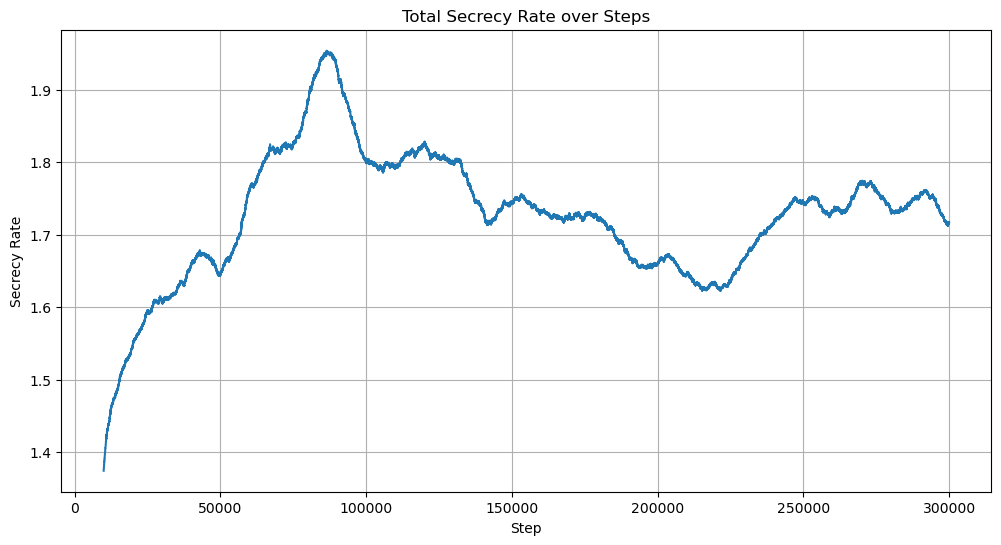

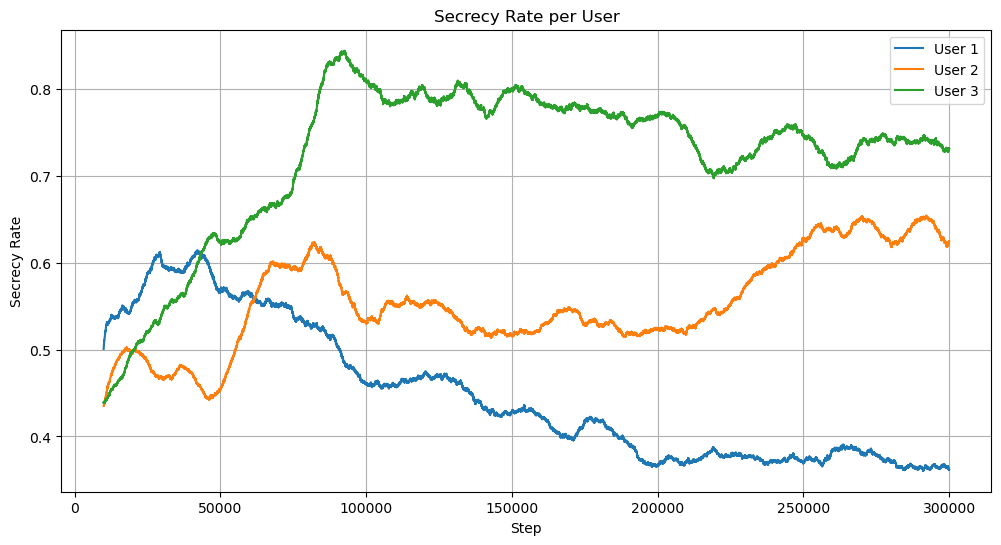

Plots saved as total_secrecy_rate.png and user_secrecy_rates.png


In [11]:
# --- Plotting ---
print("Training complete. Plotting results from CSV...")

csv_dir = "train_csv_2"
secrecy_file = os.path.join(csv_dir, "secrecy_rate.csv")
user_secrecy_file = os.path.join(csv_dir, "user_secrecy_rates.csv")

# 1. Total Secrecy Rate
if os.path.exists(secrecy_file):
    df_total = pd.read_csv(secrecy_file)
    if not df_total.empty:
        plt.figure(figsize=(12, 6))
        plt.plot(df_total['secrecy_rate'].rolling(window=10000).mean())
        plt.title("Total Secrecy Rate over Steps")
        plt.xlabel("Step")
        plt.ylabel("Secrecy Rate")
        plt.grid(True)
        plt.savefig("total_secrecy_rate.png")
        plt.show()

# 2. Per-User Secrecy Rate
if os.path.exists(user_secrecy_file):
    df_users = pd.read_csv(user_secrecy_file)
    if not df_users.empty:
        user_cols = [c for c in df_users.columns if c != 'step']
        
        plt.figure(figsize=(12, 6))
        for col in user_cols:
             plt.plot(df_users[col].rolling(window=10000).mean(), label=col)
        
        plt.title("Secrecy Rate per User")
        plt.xlabel("Step")
        plt.ylabel("Secrecy Rate")
        plt.legend()
        plt.grid(True)
        plt.savefig("user_secrecy_rates.png")
        plt.show()

print("Plots saved as total_secrecy_rate.png and user_secrecy_rates.png")